In [1]:
import numpy as np
import matplotlib.pyplot as plt

from modules import node, system, sensing
from modules import optimization as opt
from configs import config

noise_power = config.NOISE_POWER

In [2]:
tx = node.TX(x=0, y=0, z=10)
rx = node.RX(x=50, y=50, z=1.5)
ris = node.RIS(x=10, y=50, z=2, N=150)
sys = system.System(tx, ris, rx)

is_los = False
N_samples = 4500
n_loop = 5000

figure_name = f'fig_cdf_N{ris.N}_LOS.pdf' if is_los else f'fig_cdf_N{ris.N}_NLOS.pdf'

In [3]:
all_born = []

for i in range(n_loop):
    print("---------------------------")
    print(f"Computing LOOP {i}")
    sys.gen_channels(is_los=is_los)

    # Stage 0: sending samples and collect observation:
    X = np.zeros(shape=(sys.ris.N, N_samples))
    y = np.zeros(shape=(N_samples, 1))
    for j in range(N_samples):
        # generate a random ris setting
        sys.ris.set_random_binary_phase_shifts()
        x = sys.ris.vector_x
        X[:, j] = x.flatten()
        y[j] = sys.cal_snr() - sys.c_true

    sens = sensing.Sensing(B=1500, N=sys.ris.N)
    M_est, w_est, _ = sens.solve(X=X, y=y, convergence_plot=False) # Stage 1: sensing
    M_est_proj = sens.project_to_psd_lowrank(M_est, r=2) # projection to low rank
    sys.ris.vector_x = opt.solve_our_optimization(M_est_proj, w_est) # Stage 2: optimization
    sys.ris.theta = np.arccos(sys.ris.vector_x)
    born = 10 * np.log10(sys.cal_snr())
    
    all_born.append(born)

---------------------------
Computing LOOP 0
---------------------------
Computing LOOP 1
---------------------------
Computing LOOP 2
---------------------------
Computing LOOP 3
---------------------------
Computing LOOP 4
---------------------------
Computing LOOP 5
---------------------------
Computing LOOP 6
---------------------------
Computing LOOP 7
---------------------------
Computing LOOP 8
---------------------------
Computing LOOP 9
---------------------------
Computing LOOP 10
---------------------------
Computing LOOP 11
---------------------------
Computing LOOP 12
---------------------------
Computing LOOP 13
---------------------------
Computing LOOP 14
---------------------------
Computing LOOP 15
---------------------------
Computing LOOP 16
---------------------------
Computing LOOP 17
---------------------------
Computing LOOP 18
---------------------------
Computing LOOP 19
---------------------------
Computing LOOP 20
---------------------------
Computing LOOP 2

In [4]:
all_rms = []
all_rfocus = []
all_csm = []
all_perfect = []

for i in range(n_loop):
    if i%100==0:
        print("Computing loop ", i)
    sys.gen_channels(is_los=is_los)
    
    # sending samples and collect observation:
    X = np.zeros(shape=(sys.ris.N, N_samples))
    y = np.zeros(shape=(N_samples, 1))

    for j in range(N_samples):
        # generate a random ris setting
        sys.ris.set_random_binary_phase_shifts()
        x = sys.ris.vector_x
        X[:, j] = x.flatten()
        y[j] = sys.cal_snr() - sys.c_true
    
    # RMS
    sys.ris.vector_x = opt.RMS(X, y)
    rms = 10 * np.log10(sys.cal_snr())
    # RFocus
    sys.ris.vector_x = opt.RFocus(X, y)
    rfocus = 10 * np.log10(sys.cal_snr())
    # Conditional Sample Mean
    sys.ris.vector_x = opt.CSM(X, y)
    csm = 10 * np.log10(sys.cal_snr())
    # Perfect_csi
    sys.ris.theta, sys.ris.vector_x = opt.perfect_csi(h_0=sys.h_0, h_=sys.h)
    perfect_csi = 10 * np.log10(sys.cal_snr())
    
    all_rms.append(rms)
    all_rfocus.append(rfocus)
    all_csm.append(csm)
    all_perfect.append(perfect_csi)

Computing loop  0
Computing loop  100
Computing loop  200
Computing loop  300
Computing loop  400
Computing loop  500
Computing loop  600
Computing loop  700
Computing loop  800
Computing loop  900
Computing loop  1000
Computing loop  1100
Computing loop  1200
Computing loop  1300
Computing loop  1400
Computing loop  1500
Computing loop  1600
Computing loop  1700
Computing loop  1800
Computing loop  1900
Computing loop  2000
Computing loop  2100
Computing loop  2200
Computing loop  2300
Computing loop  2400
Computing loop  2500
Computing loop  2600
Computing loop  2700
Computing loop  2800
Computing loop  2900
Computing loop  3000
Computing loop  3100
Computing loop  3200
Computing loop  3300
Computing loop  3400
Computing loop  3500
Computing loop  3600
Computing loop  3700
Computing loop  3800
Computing loop  3900
Computing loop  4000
Computing loop  4100
Computing loop  4200
Computing loop  4300
Computing loop  4400
Computing loop  4500
Computing loop  4600
Computing loop  4700
Comp

In [5]:
all_gcsm = []

for i in range(n_loop):
    if i%100==0:
        print("Computing loop ", i)
    sys.gen_channels(is_los=is_los)
    sys.run_GCSM(N_samples=N_samples)
    gcsm = 10 * np.log10(sys.cal_snr())

    all_gcsm.append(gcsm)

Computing loop  0
Computing loop  100
Computing loop  200
Computing loop  300
Computing loop  400
Computing loop  500
Computing loop  600
Computing loop  700
Computing loop  800
Computing loop  900
Computing loop  1000
Computing loop  1100
Computing loop  1200
Computing loop  1300
Computing loop  1400
Computing loop  1500
Computing loop  1600
Computing loop  1700
Computing loop  1800
Computing loop  1900
Computing loop  2000
Computing loop  2100
Computing loop  2200
Computing loop  2300
Computing loop  2400
Computing loop  2500
Computing loop  2600
Computing loop  2700
Computing loop  2800
Computing loop  2900
Computing loop  3000
Computing loop  3100
Computing loop  3200
Computing loop  3300
Computing loop  3400
Computing loop  3500
Computing loop  3600
Computing loop  3700
Computing loop  3800
Computing loop  3900
Computing loop  4000
Computing loop  4100
Computing loop  4200
Computing loop  4300
Computing loop  4400
Computing loop  4500
Computing loop  4600
Computing loop  4700
Comp

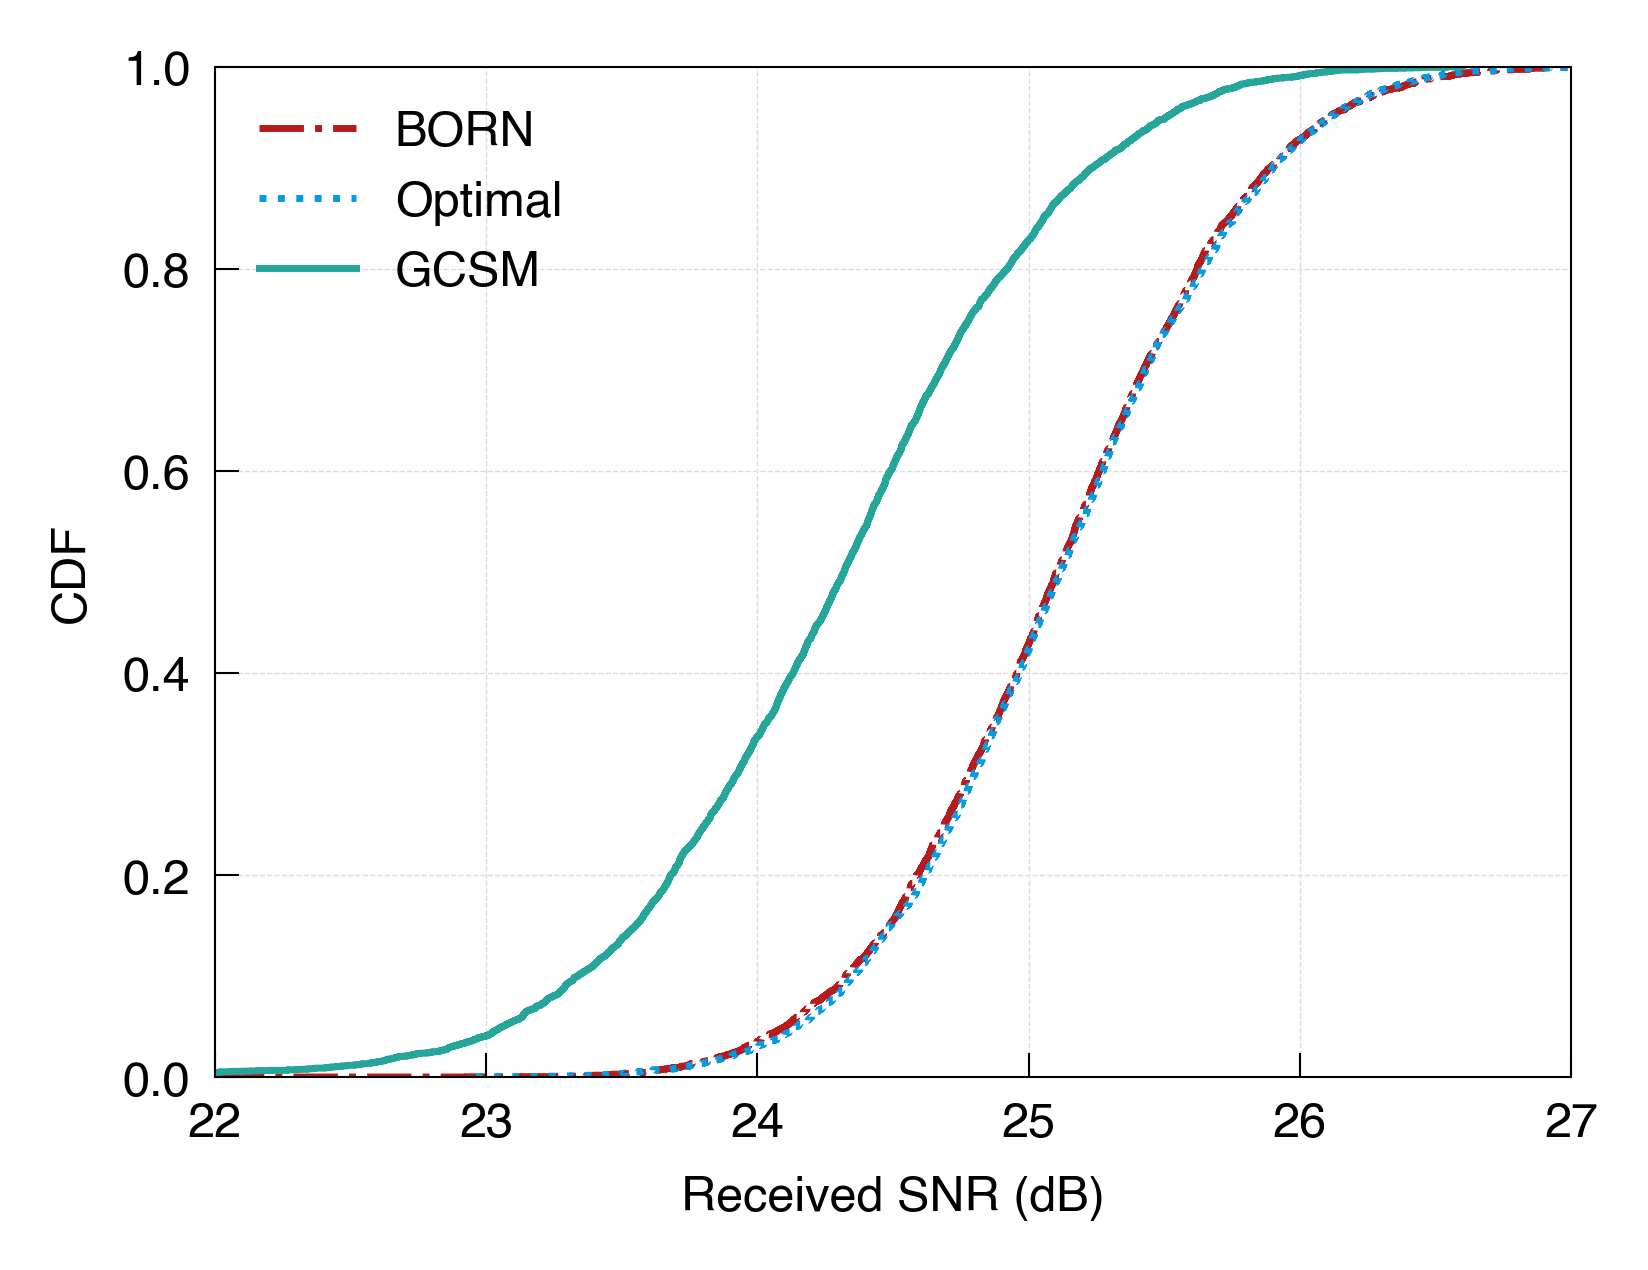

In [6]:
def plot_multiple_cdfs(data_lists, labels):
    """
    Plots the Cumulative Distribution Functions (CDFs) of multiple lists of values on the same plot.
    
    Parameters:
    data_lists (list of lists): A list containing multiple lists of numerical values.
    labels (list of str, optional): Labels for each CDF in the legend. If None, uses default labels for specific use case.
    """
    colors = ['#B71C1C', '#039BE5', '#26A69A', '#FF6F00', '#616161', '#BA68C8', '#EC407A']
    plt.figure(figsize=(3.5, 2.625), dpi=500)
    #Font setup
    plt.rcParams['font.family'] = 'Helvetica'
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    plt.rcParams['text.usetex'] = False
    plt.rcParams['font.size'] = 7
    plt.rcParams['legend.fontsize'] = 7

    plt.rcParams['xtick.minor.visible'] = False
    plt.rcParams['ytick.minor.visible'] = False
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['xtick.major.width'] = 0.3
    plt.rcParams['ytick.major.width'] = 0.3
    plt.rcParams['axes.linewidth'] = 0.3
    
    for i, x in enumerate(data_lists):
        # Sort the data
        sorted_x = np.sort(x)
        # Compute the CDF values
        y = np.arange(1, len(x) + 1) / len(x)
        # Plot the CDF
        if labels[i] == 'BORN':
            plt.plot(sorted_x, y, drawstyle='steps-post', label=labels[i], ls='-.', color=colors[i], linewidth=1.0)
        elif labels[i] == 'Optimal':
            plt.plot(sorted_x, y, drawstyle='steps-post', label=labels[i], ls=':', color=colors[i], linewidth=1.0)
        else:
            plt.plot(sorted_x, y, drawstyle='steps-post', label=labels[i], color=colors[i], linewidth=1.0)
    
    plt.ylabel('CDF')
    plt.xlabel('Received SNR (dB)')
    plt.xlim([22, 27])
    plt.ylim([0, 1])
    leg = plt.legend(frameon=False, edgecolor='black', framealpha=0.8)
    leg.get_frame().set_linewidth(0.4)
    plt.grid(color='gainsboro', linestyle='--', linewidth=0.2)
    plt.savefig(figure_name, dpi=500, bbox_inches='tight', pad_inches=0.05)


plot_multiple_cdfs([all_born, all_perfect, all_gcsm], labels=['BORN', 'Optimal', 'GCSM'])